[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/tobyrmanders/statistical-rethinking/blob/main/code/chapter_11.ipynb)

In [4]:
import torch
from torch import tensor
import torch.distributions.constraints as constraints

import pyro
from pyro import distributions as dist
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import svi, Predictive
from pyro import optim
import pyro.ops.stats as stats


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from rethinking import MAP, coef, extract_samples, link, precis, sim, vcov

# Easy

In [5]:
# 11E1

p = 0.35
np.log(p / (1 - p))

-0.6190392084062235

In [7]:
# 11E2

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

inv_logit(3.2)

0.9608342772032357

In [9]:
# 11E3

# Each one unit increase in the independent variable causes a 1.7x log odds. So odds increase by:
np.exp(1.7)

5.4739473917272

# Medium

## 11M1

With the aggregated organization (binomial regression), the order of individual trials does not matter. The likelihood function is the likelihod of seeing m successes in n trials. With the disaggregated organization (logistic regression), the order matters. It is the likelihood of seeing that exact sequence.

## 11M2

log(lambda) will increase by 1.7x for each unit change in x, so the outcome will increase by:

In [10]:
np.exp(1.7)

5.4739473917272

## 11M3

The outcome for a binomial GLM has a lower bound of 0 and an upper bound of n trials, corresponding to a binomial proportion between 0 and 1. The inverse logit transforms an unbounded real number into a number between 0 and 1. 

## 11M4

The outcome space is between 0 and infinity. The log link takes a real value (-inf, +inf) and maps it to (0, +inf). 

## 11M5

Using a logit link instead of a log link would imply that the counts being modeled would never be greater than 1 for an exposure. It would also imply a diminishing response to the predictor variable for means close to 1. 
I'm not sure if there would be a context for this, but possibly very rare events?

edit: Google says may be appropriate for overdispersed rare events?

## 11M6

Both: binary outcome, stationary proportion

Poisson: special case where upper limit is unknown

## 11M7

In [14]:
df = pd.read_csv('../data/chimpanzees.csv', sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


In [51]:
df.actor.nunique()

7

In [52]:
df.actor.unique()

array([1, 2, 3, 4, 5, 6, 7])

In [97]:
df['actor'] = df.actor - 1

In [175]:
from pyro import sample, plate, distributions as dist
from pyro.infer import config_enumerate
from torch import zeros, ones

pyro.clear_param_store()

num_actors = df.actor.nunique()

@config_enumerate
def model(left=None, actor=None):
    a = sample("a", dist.Normal(zeros(num_actors), ones(num_actors) * 1.5).to_event())
    N = len(left) if left is not None else 10
    with plate('data', N):
        actor_id = sample('actor_id', dist.Categorical(ones(num_actors)), obs=actor, infer={'enumerate': 'parallel'}).long()
        l = sample("left", dist.Binomial(logits=a[actor_id]), obs=left)
        return a, actor_id, l

In [189]:
model()

(tensor([-0.0045, -0.4386, -2.5647,  0.7535, -1.8596,  0.6381, -1.2319]),
 tensor([5, 2, 3, 4, 4, 6, 6, 0, 3, 0]),
 tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0.]))

Elbo loss: 1259.005126953125
Elbo loss: 1259.0047607421875
Elbo loss: 1259.0048828125
Elbo loss: 1259.0048828125
Elbo loss: 1259.0048828125
Elbo loss: 1259.0048828125
Elbo loss: 1259.0048828125
Elbo loss: 1259.0048828125
Elbo loss: 1259.0048828125
Elbo loss: 1259.0048828125


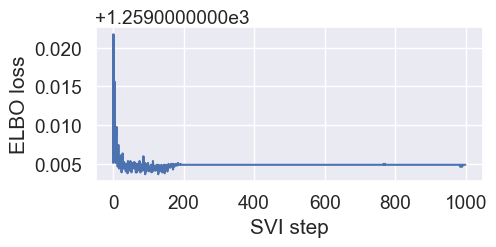

In [196]:
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.optim import Adam


left = torch.tensor(df.pulled_left.values)
actor = torch.tensor(df.actor.values)

guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, Adam({"lr": 0.02}), TraceEnum_ELBO())
losses = []
for step in range(1000):
    loss = svi.step(left, actor)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [230]:
laplace_guide = guide.laplace_approximation(left, actor)
# laplace_guide.quantiles([0.3, 0.7])
for p in laplace_guide.parameters():
    print(p)

In [233]:
post = laplace_guide.get_posterior()

In [235]:
print(post.loc)
post.covariance_matrix

tensor([-0.3281,  3.7441, -0.6146, -0.6146, -0.3281,  0.5557,  1.9622])


tensor([[0.0557, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4831, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0594, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0594, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0557, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0584, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1216]])

In [242]:
laplace_guide.parameters()
for param in laplace_guide.parameters():
    print(type(param), param.size())

In [260]:
with plate('laplace_samples', 10000): 
    samples = laplace_guide()

In [261]:
samples['a']

tensor([[-4.6112e-01,  2.4944e+00, -4.5344e-01,  ..., -2.3389e-01,
          1.0162e+00,  2.6904e+00],
        [-9.0827e-02,  5.4895e+00, -6.5150e-01,  ..., -4.7354e-01,
          4.4608e-01,  2.0680e+00],
        [-2.7277e-01,  2.8433e+00, -8.1206e-01,  ..., -1.8473e-01,
          5.7855e-01,  2.0118e+00],
        ...,
        [-6.3021e-01,  3.6856e+00, -6.6690e-01,  ..., -7.3328e-01,
          6.0787e-01,  2.1508e+00],
        [ 1.2512e-03,  2.8444e+00, -5.3186e-01,  ..., -5.1300e-01,
          7.5578e-01,  2.1877e+00],
        [-7.6949e-01,  3.9162e+00, -1.7365e-01,  ..., -3.1725e-01,
          4.7763e-01,  2.3201e+00]])

In [262]:
post = pd.DataFrame({
    f'a_{i}': samples['a'][:, i] for i in range(7)
})
post.head()

,a_0,a_1,a_2,a_3,a_4,a_5,a_6
0,-0.461120,2.494368,-0.453444,-0.773122,-0.233890,1.016211,2.690375
1,-0.090827,5.489487,-0.651504,-0.196379,-0.473542,0.446080,2.067959
2,-0.272770,2.843333,-0.812057,-0.885768,-0.184733,0.578553,2.011775
3,-0.363064,2.646391,-0.408428,-0.822678,-0.156141,0.856961,2.355719
4,-0.316787,4.842920,-0.669769,-0.774688,-0.437810,0.436272,1.378689


<AxesSubplot:ylabel='Count'>

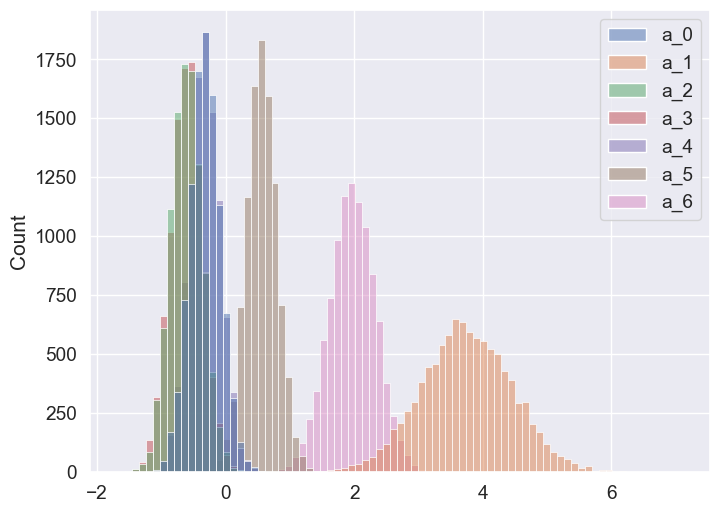

In [263]:
sns.histplot(data=post)

In [264]:
post_prob = post.transform(inv_logit)

In [ ]:
sns.histplot(data=post_prob)